<h1>
<center>
Module 4: Automating tree-building
</center>
</h1>
<div class=h1_cell>
<p>
In this module we will generate trees automatically. The goal is to write a function that will take as arguments a table and a set of columns to consider as node splitters. The function will return a tree that is the best possible using Gini as a measure. Once we have the tree, we can use it to compute accuracy, F1, etc.
<p>

</div>

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('/content/gdrive/My Drive/class_tables/titanic_wrangled_week2.csv', 'r') as f:
  titanic_table = pd.read_csv(f)

In [0]:
with open('/content/gdrive/My Drive/class_tables/titanic_results_week2.csv', 'r') as f:
  titanic_results = pd.read_csv(f)

In [0]:
pd.set_option('display.max_columns', None)

In [5]:
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,ok_child,pclass_1,pclass_2,pclass_3
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,0,0,1


<h2>
Import the library files
</h2>
<p>
<div class=h1_cell>
<p>
We created 3 functions from module 3 that we will need in this module. Below assumes you have added the 3 new functions to a new file called `library_w19_week3.py` on your computer.
</div>

In [6]:
!rm library_w19_week3.py

rm: cannot remove 'library_w19_week3.py': No such file or directory


In [7]:
from google.colab import files
files.upload()
# choose the file on your computer to upload it then


Saving library_w19_week3.py to library_w19_week3.py


{'library_w19_week3.py': b"def predictor_case(row, pred, target):\n\tcase_dict = {(0,0): 'true_negative', (1,1): 'true_positive', (0,1): 'false_negative', (1,0): 'false_positive'}\n\tactual = row[target]\n\tprediction = row[pred]\n\tcase = case_dict[(prediction, actual)]\n\treturn case\n\ndef accuracy(cases):\n    tp = cases['true_positive']\n    tn = cases['true_negative']\n    fp = cases['false_positive']\n    fn = cases['false_negative']\n    return (tp + tn)/(tp+tn+fp+fn)\n\ndef f1(cases):\n    #the heart of the matrix\n    tp = cases['true_positive']\n    fn = cases['false_negative']\n    tn = cases['true_negative']\n    fp = cases['false_positive']\n    \n    #other measures we can derive\n    recall = 1.0*tp/(tp+fn)  # positive correct divided by total positive in the table\n    precision = 1.0*tp/(tp+fp) # positive correct divided by all positive predictions made\n    \n    #now for the one we want\n    f1 = 2/(1/recall + 1/precision)\n    \n    return f1\n\ndef informedness(ca

In [8]:
from library_w19_week3 import *
%who function

accuracy	 f1	 gig	 gini	 informedness	 predictor_case	 probabilities	 


<h2>
What columns do we want to use
</h2>
<p>
<div class=h1_cell>
<p>
I am going to use the columns below as candidates for splitting in my trees. Note that they are all binary columns.
<p>
Also note that here is where I could do the k-1 reduction discussed in module 1. I could remove things like `sex_male` or `pclass_1`, in essence do the same thing that `drop_first` does in `get_dummies`. But I choose not to at this point. I want all the debugging info I can get.
</div>

In [0]:
splitter_columns = [
 'emb_C',
 'emb_Q',
 'emb_S',
 'emb_nan',
 'age_Child',
 'age_Adult',
 'age_Senior',
 'no_age',
 'ok_child',
 'sex_female', 
 'pclass_1',
 'pclass_2',
 'pclass_3'
]

<h1>
How to view a tree
</h1>
<p>
<div class=h1_cell>
<p>
I want to move away from having trees represented as nested if-statements in functions. That is too limiting. Instead, I want to represent a tree as data.  Here is what I propose.
<ul>
<li>A tree has a set of paths where a path connects the root node with a leaf node.</li>
<li>Each path represents a conjunction, e.g., `path1 = (sex_female and pclass_2 and emb_S)` represents a conjunction with 3 predicates/conjuncts. If all 3 are true the conjunction is true and path1 is true. If any are false, the conjunction is false and path1 is false.
</li>
<li>A path also contains a prediction: if the path is true then use the prediction attached to the path.</li>
<li>Once we have the set of paths for a tree,  we find one that is true and return its prediction.</li>
</ul>
<p>
I am using the terms conjuncts and predicates interchangeably. Actually, conjunct is the more general term for an item in a conjunction. More specifically, a predicate is a logical function that returns true or false. We will see next that our conjunctions have predicates as items.

<h1>
How to build a tree
</h1>
<p>
  The hard part is generating the set of paths for a tree. We can use Gig scores from our last module to make decisions. But still a bit complicated to incrementally build up all the paths. We will tackle that in this module.
<p>
I am going to break a path up into 2 pieces of data: the conjunction and the prediction. For the conjuncts in the conjunction, I am going to use lambda expressions. So a conjunct is a predicate that returns a true/false value.  Here is my function for building lambda expressions. The `branch` is the path we follow: 1 if true branch, 0 if false branch.
</div>

In [0]:
def build_pred(column, branch):
    return lambda row: row[column] == branch

<div class=h1_cell>
<p>
And here is a simple example of its use.
</div>

In [11]:
row1 = {'a': 1, 'b': 0, 'c': 0}

conjunction1 = [build_pred('a', 1), build_pred('b', 0), build_pred('c', 0)]  # 3 conjuncts/predicates

conjunction1  # a list of functions that return true or false, i.e., a list of predicates

[<function __main__.build_pred.<locals>.<lambda>>,
 <function __main__.build_pred.<locals>.<lambda>>,
 <function __main__.build_pred.<locals>.<lambda>>]

<div class=h1_cell>
  <h1>The good and bad of map</h1>
<p>
It seems a bit counter-intuitive, but there is not an ordering on the predicates in a path even though a tree implies
"going down a path". Each predicate asks a question about a row value. Each question is independent. Hence, we can use a map function to do them independently. And what is way cool is that there is a version of map that actually works in parallel. So we could ask all the questions at once.
</div>

In [12]:
boolean_list1 = map(lambda f: f(row1), conjunction1)  #This has potential to be parallelized
bl1 = list(boolean_list1) 
bl1

[True, True, True]

More `map` craziness. I showed you some of this in the module 0 warm-up. The `map` function returns a `map object` which is a generator. The prescribed way of getting a list from a map object is to turn it into a list. But notice the madness below. The length of `list(boolean_list1)` is 0. But once I assign it to a variable, it becomes 3. In essence, turning it into a list still keeps it in limbo. You have to do something with that list, like assign it to a var, to get the actual values out of it. Cray cray.

In [13]:
(len(list(boolean_list1)), len(bl1))  # Not good IMHO

(0, 3)

In [14]:
row2 = {'a': 1, 'b': 1, 'c': 0}
boolean_list2 = map(lambda f: f(row2), conjunction1)
bl2 = list(boolean_list2)
bl2

[True, False, True]

In [15]:
all(bl1)  # all returns true if all items in list are true

True

In [16]:
all(bl2)

False

In [17]:
repr(bl2)

'[True, False, True]'

In [18]:
#More on the crazy side

all(list(boolean_list2))  #Should be false as seen above

True

So the function `all` applied to a `map object` converted to a list returns true. You can see why above. The list is empty at this point. So same as:

In [19]:
all([])

True

<h2>
Path as dictionary
</h2>
<p>
<div class=h1_cell>
<p>
I've decided to use a dictionary to represent a path. A path has a conjunction field and a prediction field.

</div>

In [20]:
path1 = {'conjunction': conjunction1, 'prediction': 1}  # I just made up the prediction of 1
path1

{'conjunction': [<function __main__.build_pred.<locals>.<lambda>>,
  <function __main__.build_pred.<locals>.<lambda>>,
  <function __main__.build_pred.<locals>.<lambda>>],
 'prediction': 1}

<h2>
Add debugging info to conjunction
</h2>
<p>
<div class=h1_cell>
<p>
To help with debugging I decided to make each predicate in a conjunction a 2-tuple. The first item is a string that describes the predicate and the second item is the lambda expression. So conjunction1 above becomes:

</div>

In [21]:
conjunction1_full = [('a_1', build_pred('a', 1)),
                  ('b_0', build_pred('b', 0)),
                  ('c_0', build_pred('c', 0))]
conjunction1_full

[('a_1', <function __main__.build_pred.<locals>.<lambda>>),
 ('b_0', <function __main__.build_pred.<locals>.<lambda>>),
 ('c_0', <function __main__.build_pred.<locals>.<lambda>>)]

<div class=h1_cell>
<p>
My 2-tuple idea is a little easier to read. And slightly more complicated to use. You can see I now have to pull the lambda from the tuple to apply it to the row.
  <p>
 Stop and make sure you follow what is happening in the map below.
</div>

In [59]:
boolean_list3 = map(lambda pair: pair[1](row1), conjunction1_full)  # conjunction1_full is a list of 2-tuples
bl3 = list(boolean_list3)
bl3

[True, True, True]

<h2>
A tree contains a list of paths
</h2>
<p>
<div class=h1_cell>
<p>
Since a path is a dictionary, a tree contains a list of dictionaries. Note I am just making up predictions for now. We will have to deal with generating predictions for a path soon.
<p>
Also note that this is a made-up tree just to show the data structure. We will get to the actual Titanic data in a minute.
</div>

In [22]:
conjunction1_full = [('a_1', build_pred('a', 1)),
                  ('b_0', build_pred('b', 0)),
                  ('c_0', build_pred('c', 0))]

path1 = {'oonjunction': conjunction1_full, 'prediction': 1}

conjunction2_full = [('a_1', build_pred('a', 1)),
                  ('b_1', build_pred('b', 1)),  # changed to a 1
                  ('c_0', build_pred('c', 0))]

path2 = {'oonjunction': conjunction2_full, 'prediction': 0}

tree_paths = [path1, path2]
tree_paths

[{'oonjunction': [('a_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('b_0', <function __main__.build_pred.<locals>.<lambda>>),
   ('c_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'prediction': 1},
 {'oonjunction': [('a_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('b_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('c_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'prediction': 0}]

<h2>
Choose the best splitter
</h2>
<p>
<div class=h1_cell>
<p>
Ok, we know have a way to represent a tree as a list of dictionaries, where each ditionary represents one path. Let's move back to building the tree. We need a way to choose the best splitter (AKA feature or column), using gini and gig, from a candidate list of columns.
I'd like a function that will
return the sorted list where each item is a tuple (column_name, gig_score). The 0th element is the one with the highest gig score (which is the best).
<p>
Just to take an example, if we are working on the root node, the table would be the entire Titanic table. We are trying to find the best column/feature/splitter to use as the root node. We will try all of the ones in `choice_list` and compute the gig for each. We will return the list of columns sorted on their gig scores.
</div>

In [0]:
def find_best_splitter(table, choice_list, target):
  
    assert (len(table)>0),"Cannot split empty table"
    assert (target in table),"Target must be column in table"
    
    gig_scores = map(lambda col: (col, gig(table, col, target)), choice_list)  #compute tuple (col, gig) for each column
    gig_sorted = sorted(gig_scores, key=lambda item: item[1], reverse=True)  # sort on gig
    return gig_sorted

In [34]:
find_best_splitter(titanic_table, splitter_columns, 'Survived')

[('sex_female', 0.1396479574728524),
 ('pclass_3', 0.049137852428292605),
 ('pclass_1', 0.03866453536487213),
 ('emb_C', 0.013388557365673015),
 ('emb_S', 0.011461161069371395),
 ('ok_child', 0.010321527428076904),
 ('pclass_2', 0.004121814088680398),
 ('no_age', 0.0040207042231273915),
 ('emb_nan', 0.0017082345882156735),
 ('age_Child', 0.0006257143143247879),
 ('age_Senior', 0.00048458255066557987),
 ('age_Adult', 0.00019771072603869122),
 ('emb_Q', 6.303036606203349e-06)]

<h2>
Follow a path to generate a sub-table
</h2>
<p>
<div class=h1_cell>
<p>
As we are building our tree, we will need to know what the subtable looks like at the end of a path (as far as we have completed it). We need to know this so we can use `find_best_splitter` above. The sub-table we generate at the end of the path will be the `table` argument of `find_best_splitter`.
<p>
Assume we have a `conjunction` that is a list of tuples. The 0th item in the tuple is string and 1st item in tuple is the predicate (i.e., a lambda expression that returns 0 or 1). The general strategy is to go down the conjunction, one by one, and use each predicate to split the starting table (e.g., the `titanic_table`) into smaller and smaller sub-tables. We can do this with a simple pandas method, where f is the predicate.
<p>
`sub_table = sub_table.loc[f]`
<p>
Pretty cool, huh. In essence, build a new table with all rows where `f` returns true. The `loc` method will pass each row to `f` (happens behind the scenes).
<p>
Here is an iterative version of the function we need. It is probably the most readable.
<p>
<pre><code>
def generate_table(table, conjunction):
    sub_table = table
    for pair in conjunction:
        f = pair[1]  # the function is the 2nd item in the pair
        sub_table = sub_table.loc[f]  # keep "reducing" the subtable by filtering on f
    return sub_table
</code></pre>
<p>
I've chosen to use a functional style instead, using `reduce`. I like both map and reduce because they have the potential of being parallelized. Make sure you can get your head around my code below. 
</div>

In [0]:
from functools import reduce

def generate_table(table, conjunction):
  
    assert (len(table)>0),"Cannot generate from empty table"

    sub_table = reduce(lambda subtable, pair: subtable.loc[pair[1]], conjunction, table)
    return sub_table

<div class=h1_cell>
<p>
I'll build a test conjunction and try it out. If you do it by hand, you will see that the resulting table only has 11 passengers, and all of them survived.
</div>

In [0]:
conjunction_test = [('sex_female_0', build_pred('sex_female', 0)),
   ('ok_child_1', build_pred('ok_child', 1)),
   ('pclass_3_0', build_pred('pclass_3', 0))]

res = generate_table(titanic_table, conjunction_test)

In [29]:
res.describe()  # Notice the table always has 1 for Survived

,Survived,Pclass,Age,SibSp,Parch,Fare,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_Child,age_Adult,age_Senior,sex_female,sex_male,ok_child,pclass_1,pclass_2,pclass_3
count,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.000000,11.0,11.000000,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.000000,11.000000,11.0
mean,1.0,1.818182,2.295455,0.818182,1.363636,43.560227,0.0,2.295455,0.090909,0.0,0.909091,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.181818,0.818182,0.0
std,0.0,0.404520,2.207099,0.603023,0.504525,40.178358,0.0,2.207099,0.301511,0.0,0.301511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404520,0.404520,0.0
min,1.0,1.000000,0.670000,0.000000,1.000000,14.500000,0.0,0.670000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0
25%,1.0,2.000000,0.875000,0.500000,1.000000,22.375000,0.0,0.875000,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.000000,0.0
50%,1.0,2.000000,1.000000,1.000000,1.000000,29.000000,0.0,1.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.000000,0.0
75%,1.0,2.000000,3.000000,1.000000,2.000000,38.002100,0.0,3.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.000000,0.0
max,1.0,2.000000,8.000000,2.000000,2.000000,151.550000,0.0,8.000000,1.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,0.0


In [30]:
vc = res['Survived'].value_counts() # Just to verify
vc

1    11
Name: Survived, dtype: int64

Note that the `value_counts` method does not list the count for 0, which would be 0. It only lists the values it sees. There are no 0s in the Survived column so no entry for 0. We will have to be careful with this later. For instance, this won't work

In [31]:
vc[0]  #hope it will return 0 but get error instead

KeyError: ignored

<h2>
Compute the prediction for a path
</h2>
<p>
<div class=h1_cell>
<p>
First, we will assume that the leaf table has been computed by `generate_table` (see above). So we have the sub-table that is generated by filtering with the predicates in a conjunction. Now we can just count the values of 0 and 1 in the target column, which is `Survived` in our case. Largest case wins. Ties go to `0`.
<p>

</div>

In [0]:
def compute_prediction(table, target):
  
    assert (len(table)>0),"Cannot predict from empty table"
    assert (target in table),"Target must be column in table"
    
    counts = table[target].value_counts()  # counts looks like {0: v1, 1: v2}

    if 0 not in counts:
        prediction = 1
    elif 1 not in counts:
        prediction = 0
    elif counts[1] > counts[0]:  # ties go to 0 (negative)
        prediction = 1
    else:
        prediction = 0

    return prediction
  

<h2>
Ok, the big enchilada
</h2>
<p>
<div class=h1_cell>
<p>
The full tree-building function is below. I am going to go through the function a bit at a time.
<div class=code_block>
<pre>
<code>
def build_tree_iter(table, choices, target, hypers={} ):

    assert (len(choices)>0),"Must have at least one column in choices"
    assert (target in table), "Target column not in table"
    assert (len(table) > 1), "Table must have more than 1 row"

    k = hypers['max-depth'] if 'max-depth' in hypers else min(4, len(choices))
    gig_cutoff = hypers['gig-cutoff'] if 'gig-cutoff' in hypers else 0.0
    
    def iterative_build(k):
        columns_sorted = find_best_splitter(table, choices, target)
        (best_column, gig_value) = columns_sorted[0]
        
        #Note I add _1 or _0 to make it more readable for debugging
        current_paths = [{'conjunction': [(best_column+'_1', build_pred(best_column, 1))],
                          'prediction': None,
                          'gig_score': gig_value},
                         {'conjunction': [(best_column+'_0', build_pred(best_column, 0))],
                          'prediction': None,
                          'gig_score': gig_value}
                        ]
        k -= 1  # we just built a level as seed so subtract 1 from k
        tree_paths = []  # add completed paths here
        
        while k>0:
            new_paths = []
            for path in current_paths:
                old_conjunction = path['conjunction']  # a list of (name, lambda)
                before_table = generate_table(table, old_conjunction)  #the subtable the current conjunct leads to
                columns_sorted = find_best_splitter(before_table, choices, target)
                (best_column, gig_value) = columns_sorted[0]
                if gig_value > gig_cutoff:
                    new_path_1 = {'conjunction': old_conjunction + [(best_column+'_1', build_pred(best_column, 1))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_1 ) #true
                    new_path_0 = {'conjunction': old_conjunction + [(best_column+'_0', build_pred(best_column, 0))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_0 ) #false
                else:
                    #not worth splitting so complete the path with a prediction
                    path['prediction'] = compute_prediction(before_table, target)
                    tree_paths.append(path)
            #end for loop
            
            current_paths = new_paths
            if current_paths != []:
                k -= 1
            else:
                break  # nothing left to extend so have copied all paths to tree_paths
        #end while loop

        #Generate predictions for all paths that have None
        for path in current_paths:
            conjunction = path['conjunction']
            before_table = generate_table(table, conjunction)
            path['prediction'] = compute_prediction(before_table, target)
            tree_paths.append(path)
        return tree_paths

    return {'paths': iterative_build(k), 'weight': None}
</code>
</pre>
</div>
</div>

<div class=h1_cell>
<p>
Let's start with:
<p>
<pre><code>
def build_tree_iter(table, choices, target, hypers={} ):

    assert (len(choices)>0),"Must have at least one column in choices"
    assert (target in table), "Target column not in table"
    assert (len(table) > 1), "Table must have more than 1 row"

    k = hypers['max-depth'] if 'max-depth' in hypers else min(4, len(choices))
    gig_cutoff = hypers['gig-cutoff'] if 'gig-cutoff' in hypers else 0.0
</code></pre>
<p>
Our tree building function takes 4 arguments: the table we are working with, the initial set of columns to consider when splitting, the target column, and a dictionary (hypers) with hyper parameters. You can see that I am checking for a key of `max-depth`. This will say how many levels deep we want our tree to be. The `gig-cutoff` is used to say when we believe new splitting won't get us very far - if the gig value on a path is not greater than this value, stop trying to add to the path. Time to call it quits and build a leaf node.
<p>
Remeber when we go to check the `gig-cutoff`, we want to use greater-than and not greater-than-or-equal. We want to avoid gig values of 0: they can lead to empty tables.
</div>

<h2>
The iterative cycle to generate levels
</h2>
<p>
<div class=h1_cell>
<p>
The general idea is that we will iterate over a set of paths and continue to extend them until either we reach the target depth or the gig score is too low. Here is the head of the inner function that will do the building. What is going on is that the top code is only executed once: it is not in a loop. It does the initial splitting of the root table to produce 2 paths that are contained in `current_paths`. At this point we do not know if one or both paths will end up as a legit path. A legit path is formed by adding a prediction to the path. Legit paths are added to tree_paths. What is not a legit path? A path that still is being built up - it has not reached its end point yet.
<p>
<div class='code_block'>
<pre><code>
      def iterative_build(k):
        columns_sorted = find_best_splitter(table, choices, target)
        (best_column, gig_value) = columns_sorted[0]
        
        #Note I add _1 or _0 to make it more readable for debugging
        current_paths = [{'conjunction': [(best_column+'_1', build_pred(best_column, 1))],
                          'prediction': None,
                          'gig_score': gig_value},
                         {'conjunction': [(best_column+'_0', build_pred(best_column, 0))],
                          'prediction': None,
                          'gig_score': gig_value}
                        ]
        k -= 1  # we just built a level as seed so subtract 1 from k
        tree_paths = []  # add completed paths here
</code></pre>
</div>
We will use the variable `tree_paths` to store the paths we have generated. We start it as empty. Note that `tree_paths` does not need to be ordered. I could have also used a `set` to hold the paths.
<p>
We will seed the list of paths with the root node. We will find the best column to use as a splitter using the full table as the starting point. We will get back a tuple of `(best_column, value)` where `best_column` is the column name and `value`  is the gig value.
<p>
I seed `current_paths` with the 2 branches the column generates. Given we are generating a binary tree, we always get 2 branches from a single column. After I do this seeding, I have:
<pre><code>
current_paths = [[('sex_female_1', lambda row: row['sex_female'] == 1)],
                     [('sex_female_0', lambda row: row['sex_female'] == 0)]]
</code></pre>
My goal now is to build these 2 paths up by continually splitting and adding on to them. If the value of k is 1, I am actually done at this point. I just have to get the predictions and add the 2 paths to tree_paths`. What if k is 2? Then I am not done. I have 2 partial paths and should eventually end up with 4 separate paths, each with 2 predicates. Convince yourself that a binary decision tree of depth 2 has 4 paths.
<p>
Why do I subtract 1 from my counter `k`? Because I just added a level, right? I seeded the root node. I set `tree_paths` to empty and will add completed paths to it as I go.
<p>
<pr><code>

k -= 1  # we just built a level as seed so subtract 1 from k
tree_paths = []  # add completed paths here
</code></pre>
</div>


<h2>
Start the iteration
</h2>
<p>
<div class=h1_cell>
<p>
You can see I am using a while loop based on k (the max depth of the tree). So what I want to do on each iteration is build all the paths out a level. In this way, I am doing a breadth-first generation of the tree. For those looking for extra credit, see if you can build a depth-first version using recursion. It's not a slam-dunk!
<p>
<div class='code_block'>
<pre>
<code>
        while k>0:
            new_paths = []
            for path in current_paths:
                old_conjunction = path['conjunction']  # a list of (name, lambda)
                before_table = generate_table(table, old_conjunction)  #the subtable the current conjunct leads to
                columns_sorted = find_best_splitter(before_table, choices, target)
                (best_column, gig_value) = columns_sorted[0]
</code>
</pre>
</div>
I'll use `new_paths` to store the modifications I make to existing paths. The for loop will go through each of the existing paths. As a reminder, a path conjunction is a list of tuples. Each tuple has a string that describes the choice being checked and a lambda that does the check.
<p>
For the conjunction in play, I first build the sub-table it generates using `generate_table`. I then find the best splitter. I now have the name of the best column and its gig_value. This sets me up for the next phase in the for loop.
</div>


<h2>
Extend the number of paths
</h2>
<p>
<div class=h1_cell>
<p>
Let's assume that the gig value is greater than the cutoff: we are still feeling ok with the current path so will go ahead and extend it. In that case we want to replace the current path with 2 new paths based on the column we find that makes the best splitter. A split gives a true and a false branch so we add one each to get the 2 new paths. 
<p>
<div class='code_block'>
<pre><code>
                if gig_value > gig_cutoff:
                    new_path_1 = {'conjunction': old_conjunction + [(best_column+'_1', build_pred(best_column, 1))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_1 ) #true
                    new_path_0 = {'conjunction': old_conjunction + [(best_column+'_0', build_pred(best_column, 0))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_0 ) #false
                else:
                    #not worth splitting so complete the path with a prediction
                    path['prediction'] = compute_prediction(before_table, target)
                    tree_paths.append(path)
            #end for loop
</code></pre>
</div>
  <p>
To look at an example of the then clause above, assume that the current path we are looking at has a conjunction of this form:
```
[('sex_female_1, lambda ...)]
```
So it has a single conjunct/predicate. We now want to use it as the basis for 2 new conjunctions. Assume that `find_best_splitter` returns `pclass_3` as the best column. After we are done, we will have replaced the single conjunction with 2 new conjunctions as below:
<p>
<pre><code>
[('sex_female_1', lambda ...), ('pclass_3_1', lambda ...)]  #true branch of split
[('sex_female_1', lambda ...), ('pclass_3_0', lambda ...)]  #false branch of split
</code></pre>
<p>
Both of these would be added to `new_paths`, replacing `[('sex_female_1, lambda ...)]`. It's kind of like a cell dividing: 1 cell splits into 2, 2 into 4, etc.
<p>
Where does the splitting stop? Looking at the else clause, if the gig value is not greater than the cutoff, we do not double the conjunction. Instead we treat it as leading to a leaf. We have to compute the prediction we will make for this leaf. The prediction is simply the target column value (0 or 1) with the highest probability in the table we generated. The last thing we do is add the completed path to tree_paths. Note that once the else clause is taken, the path is removed from further expansion. In particular, it is not copied to new_path.
<p>
The for loop will continue iterating over the set of paths we have currently. It is the cell splitter. Give it a set of cells (conjunctions), and it will split each into 2 by adding a new node and 2 branches.
</div>


<h2>
End of for and while loops
</h2>
<p>
<div class=h1_cell>
<p>
When we reach the end of the for loop, we have iterated over all the existing paths to try to extend them. In essence we have completed a new level. If new_paths is empty, we had no luck with extending any of them. We break out of the while loop - there is no point in iterating any further. Why would `new_paths` be empty? Because all the paths lead to a too-low gig score. If we have paths remaining we get set up for the next iteration through the while loop. Each iteration of the while loop adds a new level to the tree.
<p>
<pre><code>
    #end for loop

    current_paths = new_paths
    if current_paths != []:
        k -= 1
    else:
        break  # nothing left to extend so have copied all paths to tree_paths
        
#end while loop
</code></pre>
<p>

</div>

<h2>
Last step, generate predictions for paths that need them
</h2>
<p>
<div class=h1_cell>
<p>
The paths in tree_paths have predictions. The paths in current_paths do not. Loop through and add a prediction to each.
<p>
<pre><code>
#Generate predictions for all paths that have None
for path in current_paths:
    conjunction = path['conjunction']
    before_table = generate_table(table, conjunction)
    path['prediction'] = compute_prediction(before_table, target)
    tree_paths.append(path)
return tree_paths

</code></pre>
<p>
Finally, package up the paths into a dictionary that will represent the tree. The `weight` key will be used in later modules when we look at giving a tree more or less say in a prediction. You can ignore it for now.
<p>
<pre><code>
return {'paths': iterative_build(k), 'weight': None}
</code></pre>
</div>

In [0]:
def build_tree_iter(table, choices, target, hypers={} ):

    assert (len(choices)>0),"Must have at least one column in choices"
    assert (target in table), "Target column not in table"
    assert (len(table) > 1), "Table must have more than 1 row"
    
    k = hypers['max-depth'] if 'max-depth' in hypers else min(4, len(choices))
    gig_cutoff = hypers['gig-cutoff'] if 'gig-cutoff' in hypers else 0.0
    
    def iterative_build(k):
        columns_sorted = find_best_splitter(table, choices, target)
        (best_column, gig_value) = columns_sorted[0]
        
        #Note I add _1 or _0 to make it more readable for debugging
        current_paths = [{'conjunction': [(best_column+'_1', build_pred(best_column, 1))],
                          'prediction': None,
                          'gig_score': gig_value},
                         {'conjunction': [(best_column+'_0', build_pred(best_column, 0))],
                          'prediction': None,
                          'gig_score': gig_value}
                        ]
        k -= 1  # we just built a level as seed so subtract 1 from k
        tree_paths = []  # add completed paths here
        
        while k>0:
            new_paths = []
            for path in current_paths:
                old_conjunction = path['conjunction']  # a list of (name, lambda)
                before_table = generate_table(table, old_conjunction)  #the subtable the current conjunct leads to
                columns_sorted = find_best_splitter(before_table, choices, target)
                (best_column, gig_value) = columns_sorted[0]
                if gig_value > gig_cutoff:
                    new_path_1 = {'conjunction': old_conjunction + [(best_column+'_1', build_pred(best_column, 1))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_1 ) #true
                    new_path_0 = {'conjunction': old_conjunction + [(best_column+'_0', build_pred(best_column, 0))],
                                'prediction': None,
                                 'gig_score': gig_value}
                    new_paths.append( new_path_0 ) #false
                else:
                    #not worth splitting so complete the path with a prediction
                    path['prediction'] = compute_prediction(before_table, target)
                    tree_paths.append(path)
            #end for loop
            
            current_paths = new_paths
            if current_paths != []:
                k -= 1
            else:
                break  # nothing left to extend so have copied all paths to tree_paths
        #end while loop

        #Generate predictions for all paths that have None
        for path in current_paths:
            conjunction = path['conjunction']
            before_table = generate_table(table, conjunction)
            path['prediction'] = compute_prediction(before_table, target)
            tree_paths.append(path)
        return tree_paths

    return {'paths': iterative_build(k), 'weight': None}

<h1>Try it out</h1>

Let's test tree building with different values for hyper-parameters. Start with a stump.

In [38]:
treea = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':1}) # try at level 1
print(len(treea['paths']))
treea['paths']

2


[{'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.1396479574728524,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.1396479574728524,
  'prediction': 0}]

We got our stump from last week!

In [76]:
treeb = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':2}) # try at level 2
print(len(treeb['paths']))
treeb['paths']

4


[{'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.017842505175795997,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.017842505175795997,
  'prediction': 0}]

I'd stop here and draw the tree on a piece of paper. Make sure you understand how a tree is being printed out above as 4 separate paths.

<div class=h1_cell>
<p>
Let's try it with all the columns we specified and with defaults for hypers: max-depth 4 and gig-cutoff 0 (remember, greater than 0).
</div>

In [39]:
tree1 = build_tree_iter(titanic_table, splitter_columns, 'Survived', {}) # should get 15 paths
print(len(tree1['paths']))
tree1['paths']

15


[{'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.19972989195678292,
  'prediction': 1},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('no_age_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.013706140350877138,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('no_age_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.013706140350877138,
  'prediction': 0},
 {'conjunction'

<div class=h1_cell>
<p>
Why did we only get 15 paths? Because one path was cut short. If you look closely, you can see that the first path has only 3 predicates:
<p>
```
 {'conjunction': [('sex_female_0', <function __main__.<lambda>>),
   ('ok_child_1', <function __main__.<lambda>>),
   ('pclass_3_0', <function __main__.<lambda>>)],
  'gig_score': 0.19972989195678292,
  'prediction': 1},
```
</p>
Let's verify that the gig cutoff for this path is correct. First I'll generate the table from the 3 predicates.
</div>

In [0]:
# do by hand what generate_table does for us

subtable = titanic_table.loc[titanic_table['sex_female'] == 0]
subtable = subtable.loc[subtable['ok_child'] == 1]
subtable = subtable.loc[subtable['pclass_3'] == 0]

<div class=h1_cell>
<p>
Now I'll check how many 0s and 1s are in the Survived column.
</div>

In [41]:
subtable['Survived'].value_counts()

1    11
Name: Survived, dtype: int64

<div class=h1_cell>
<p>
The table only contains survivors! So there were 11 total passengers that were not female, were less than age 8 and were not in 3rd class. And all of them survived. Convince yourself that any attempt to further extend this path, i.e., try to split the table further, will lead to a gig score of 0. And hence not pass the cutoff.
<p>
And a note to myself: it might be worth while checking for homogeneity of `before_table` prior to uselessly trying to find a splitter. So something like this:
<p>
<div class='code_block'>
<pre><code>
before_table = generate_table(table, conjunct)
if is_homogenous(before_table):
    #compute prediction and add path to tree_paths - don't need to mess with new splitter
else:
    columns_sorted = find_best_splitter(before_table, choices, target)
</code></pre>
</div>
<p>
</div>

<h2>
Now ready to do predictions
</h2>
<p>
<div class=h1_cell>
<p>
We don't need separate predictors any more. In our old-school way we were representing trees with code. Our new improved way represents trees as a data structure. We can use just a single predictor function to interpret any tree.
</div>

In [0]:
def tree_predictor(row, tree):
    
    #go through each path, one by one (could use a map instead of for loop?)
    for path in tree['paths']:
        conjuncts = path['conjunction']
        result = map(lambda tuple: tuple[1](row), conjuncts)  # potential to be parallelized
        if all(result):
            return path['prediction']
    raise LookupError('No true paths found for row: ' + str(row))

<div class=h1_cell>
<p>
Let's pull out a row and test it out.
</div>

In [43]:
row1 = titanic_table.loc[1]
row1

Survived                                                      1
Pclass                                                        1
Name          Cumings, Mrs. John Bradley (Florence Briggs Th...
Sex                                                      female
Age                                                          38
SibSp                                                         1
Parch                                                         0
Ticket                                                 PC 17599
Fare                                                    71.2833
Cabin                                                       C85
Embarked                                                      C
no_age                                                        0
filled_age                                                   38
emb_C                                                         1
emb_Q                                                         0
emb_S                                   

In [44]:
tree_predictor(row1, tree1)

1

<div class=h1_cell>
<p>
Now try for entire table.
</div>

In [45]:
titanic_results['tree_1'] = titanic_table.apply(lambda row: tree_predictor(row, tree1), axis=1)

titanic_results.head(5)

,Survived,pred_1,pred_1_type,pred_2,pred_2_type,tree_1
0,0,0,true_negative,0,true_negative,0
1,1,1,true_positive,1,true_positive,1
2,1,1,true_positive,0,false_negative,0
3,1,1,true_positive,1,true_positive,1
4,0,0,true_negative,0,true_negative,0


In [46]:
titanic_results['tree_1_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_1', target='Survived'), axis=1)
titanic_results.head()

,Survived,pred_1,pred_1_type,pred_2,pred_2_type,tree_1,tree_1_type
0,0,0,true_negative,0,true_negative,0,true_negative
1,1,1,true_positive,1,true_positive,1,true_positive
2,1,1,true_positive,0,false_negative,0,false_negative
3,1,1,true_positive,1,true_positive,1,true_positive
4,0,0,true_negative,0,true_negative,0,true_negative


In [47]:
tree_1_types = titanic_results['tree_1_type'].value_counts()
tree_1_types

true_negative     523
true_positive     211
false_negative    131
false_positive     26
Name: tree_1_type, dtype: int64

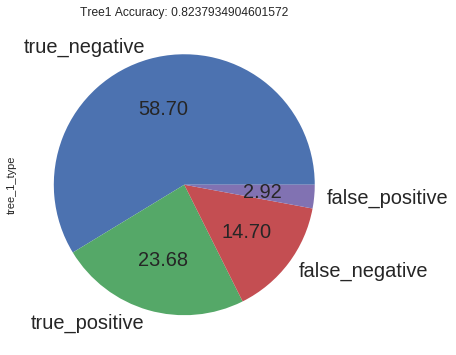

In [48]:
%matplotlib inline
tree_1_types.plot.pie(title='Tree1 Accuracy: '+str(accuracy(tree_1_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

In [49]:
f1(tree_1_types)

0.7288428324697754

In [50]:
informedness(tree_1_types)

0.5696002300834051

<h2>
Our next step is to tune the tree
</h2>
<p>
<div class=h1_cell>
<p>
We have two knobs we can twist: max depth (currently set at 4) and gig cutoff (currently set at 0). Let's try trees of different depths. First up, max depth of 3.
</div>

In [51]:
tree2 = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':3})
print(len(tree2['paths']))
tree2['paths']

8


[{'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.049107142857142794,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.049107142857142794,
  'prediction': 1},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0011556819891408443,
  'prediction': 1},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<la

We generated 8 paths so looks like no gig cutoff: we expect to get 8 paths in a binary tree of level 3.

In [53]:
titanic_results['tree_2'] = titanic_table.apply(lambda row: tree_predictor(row, tree2), axis=1)

titanic_results.head(5)

,Survived,pred_1,pred_1_type,pred_2,pred_2_type,tree_1,tree_1_type,tree_2
0,0,0,true_negative,0,true_negative,0,true_negative,0
1,1,1,true_positive,1,true_positive,1,true_positive,1
2,1,1,true_positive,0,false_negative,0,false_negative,0
3,1,1,true_positive,1,true_positive,1,true_positive,1
4,0,0,true_negative,0,true_negative,0,true_negative,0


In [54]:
titanic_results['tree_2_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_2', target='Survived'), axis=1)
titanic_results.head()

,Survived,pred_1,pred_1_type,pred_2,pred_2_type,tree_1,tree_1_type,tree_2,tree_2_type
0,0,0,true_negative,0,true_negative,0,true_negative,0,true_negative
1,1,1,true_positive,1,true_positive,1,true_positive,1,true_positive
2,1,1,true_positive,0,false_negative,0,false_negative,0,false_negative
3,1,1,true_positive,1,true_positive,1,true_positive,1,true_positive
4,0,0,true_negative,0,true_negative,0,true_negative,0,true_negative


In [55]:
tree_2_types = titanic_results['tree_2_type'].value_counts()
tree_2_types

true_negative     523
true_positive     211
false_negative    131
false_positive     26
Name: tree_2_type, dtype: int64

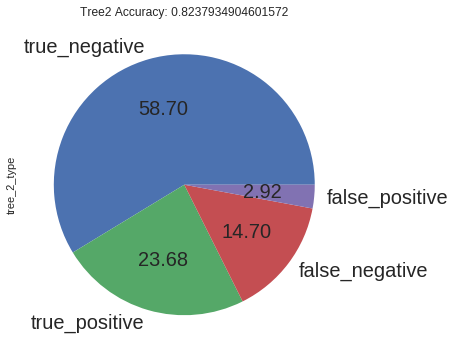

In [56]:
tree_2_types.plot.pie(title='Tree2 Accuracy: '+str(accuracy(tree_2_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

In [57]:
f1(tree_2_types)

0.7288428324697754

In [58]:
informedness(tree_2_types)

0.5696002300834051

<div class=h1_cell>
<p>
Exactly the same as with depth 4. Kind of interesting. It appears that adding a 4th level to the tree gave us no benefit. Let's keep going and try max level 2.
</div>

In [60]:
tree3 = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':2})
print(len(tree3['paths']))
tree3['paths']

4


[{'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.017842505175795997,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.017842505175795997,
  'prediction': 0}]

In [61]:
titanic_results['tree_3'] = titanic_table.apply(lambda row: tree_predictor(row, tree3), axis=1)
titanic_results['tree_3_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_3', target='Survived'), axis=1)
tree_3_types = titanic_results['tree_3_type'].value_counts()
tree_3_types

true_negative     529
true_positive     178
false_negative    164
false_positive     20
Name: tree_3_type, dtype: int64

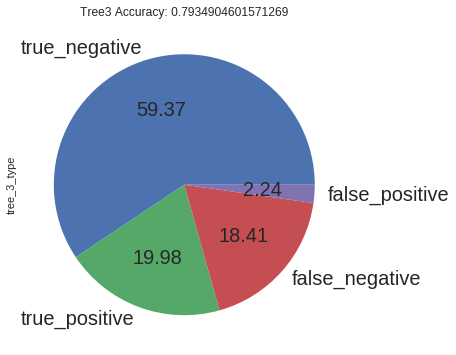

In [62]:
tree_3_types.plot.pie(title='Tree3 Accuracy: '+str(accuracy(tree_3_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

In [63]:
f1(tree_3_types)

0.6592592592592593

In [64]:
informedness(tree_3_types)

0.4840379637618637

<div class=h1_cell>
<p>
We got worse in all measures, i.e., accuracy, F1, Informedness.
<p>
Let's explore the gig cutoff a bit. I'll use max depth 3 but change the cutoff.
</div>

In [65]:
tree4 = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':3, 'gig-cutoff': .01}) #increase from 0 to .01
print(len(tree4['paths']))
tree4['paths']

7


[{'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 1},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.049107142857142794,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('emb_S_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.049107142857142794,
  'prediction': 1},
 {'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('ok_child_1', <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<la

<div class=h1_cell>
<p>We eliminated 1 path: instead of 8 we now have 7.
</div>

In [1]:
titanic_results['tree_4'] = titanic_table.apply(lambda row: tree_predictor(row, tree4), axis=1)
titanic_results['tree_4_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_4', target='Survived'), axis=1)
tree_4_types = titanic_results['tree_4_type'].value_counts()
tree_4_types

NameError: name 'titanic_table' is not defined

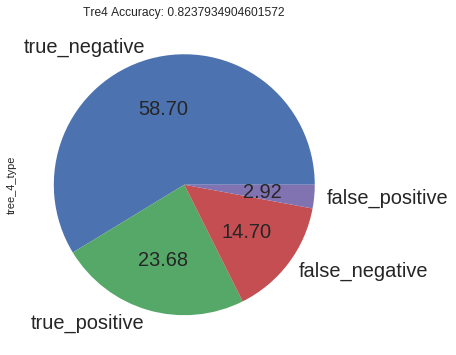

In [67]:
tree_4_types.plot.pie(title='Tre4 Accuracy: '+str(accuracy(tree_4_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

In [68]:
f1(tree_4_types)

0.7288428324697754

In [69]:
informedness(tree_4_types)

0.5696002300834051

<div class=h1_cell>
<p>
Looks like exact same results as with level 3 and cutoff 0. But now with a slightly slimmer tree, which we will see is a good thing in future modules.
<p>
Let's try bumping the cutoff slightly.
</div>

In [70]:
tree5 = build_tree_iter(titanic_table, splitter_columns, 'Survived', {'max-depth':3, 'gig-cutoff': .05})
print(len(tree5['paths']))
tree5['paths']

3


[{'conjunction': [('sex_female_0',
    <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.1396479574728524,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 0},
 {'conjunction': [('sex_female_1',
    <function __main__.build_pred.<locals>.<lambda>>),
   ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
  'gig_score': 0.0992456441378125,
  'prediction': 1}]

<div class=h1_cell>
<p>
Well, we trimmed the paths to 3. Let's see if improvement.
</div>

In [71]:
titanic_results['tree_5'] = titanic_table.apply(lambda row: tree_predictor(row, tree5), axis=1)
titanic_results['tree_5_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_5', target='Survived'), axis=1)
tree_5_types = titanic_results['tree_5_type'].value_counts()
tree_5_types

true_negative     540
false_negative    181
true_positive     161
false_positive      9
Name: tree_5_type, dtype: int64

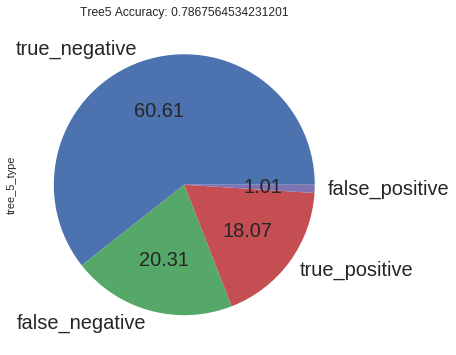

In [72]:
tree_5_types.plot.pie(title='Tree5 Accuracy: '+str(accuracy(tree_5_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

In [73]:
f1(tree_5_types)

0.62890625

In [74]:
informedness(tree_5_types)  # slightly better than depth 4

0.4543667912951779

<div class=h1_cell>
<p>
We've gone down on all measures. But we have squeezed false positives down even further. If false positives were a big concern for us, then perhaps we would be willing to live with less accuracy.
<p>
I'll stop exploration here but certainly more that could be done.
</div>

<h2>
Could this be automated?
</h2>
<p>
<div class=h1_cell>
<p>
Setting hyper-parameters is a major problem in machine learning. Instead of trying out different values ourselves, could we build a function that will search for us? In essence, take a tree and table in as input, and try reasonable combinations of the hyper-parameters. The returned result would be the best choice of hyper-parameters.
<p>
Of course the answer is yes. I might assign it as a problem in the future :)
</div>

<h2>
Another approach: Pruning
</h2>
<p>
<div class=h1_cell>
<p>
You will sometimes hear about tree pruning. This is another approach to reduce the tree by getting rid of non-useful sub-trees. In general, we would attempt to build out a full tree to its maximum depth, i.e., not attempt to limit splitting with something like gig-cutoff. Then do a bottom-up pruning process by looking at sub-trees and determining if they give us useful results. It not, replace the root of the sub-tree with a leaf.
<p>
Can this be automated? Again the answer is yes. Is it an active area of research? Not really. The reason is that newer methods have evolved to keep trees slim. We will see them soon in upcoming modules.
</div>

<h2>
Does our tree building algorithm have a name?
</h2>
<p>
<div class=h1_cell>
<p>
Not that I know of. Maybe we should name it! On the other hand, it is pretty much equivalent to the CART algorithm: ftp://ftp.boulder.ibm.com/software/analytics/spss/support/Stats/Docs/Statistics/Algorithms/14.0/TREE-CART.pdf. It is greedy (does not do backtracking). It uses Gini. The only difference is that our algorithm is breadth-first and CART is depth-first. I claim they are equivalent in terms of function. They may differ in terms of performance but nothing that should bother us.
</div>

<h2>
What about empties?
</h2>
<p>
<div class=h1_cell>
<p>
We have been finessing the problem with empty values by wrangling. We have made sure (by wrangling) that all of the columns we use have non-empty values in the Titanic data. Ditto for the Loan table. But what if a new loan applicant comes in in the future and is missing a value we need to know? For instance, what if they are missing a value for credit history? We have two choices: (1) wrangle any new rows that come in to make sure no critical empty values once tree is called to make a prediction, e.g., fill-in the value with the mean, or (2) allow empty values and handle them in the tree itself. The CART paper above suggests the latter. It suggests building "back up" splitters at each node (called surrogates officially) that can be called upon if the main splitter is handed an empty value. Of course, the value the surrogate needs can also by empty. This response lists other means of dealing with empties: https://stats.stackexchange.com/a/96458. One interesting approach listed is to go ahead and pass the row to both branches and obtain multiple predictions. Then take the majority vote. Perhaps flip a coin if a tie. I view this approach as close to a full-blown embrace of multiple predictions and voting we will see in a future module. Stay tuned.
</div>

<hr>
<h1>Write it out</h1>
<div class=h1_cell>

We did not change the main table so no need to write it out.
  <p>
    We did change the results table so write that out.
</div>

In [0]:
with open('/content/gdrive/My Drive/class_tables/titanic_results_week4.csv', 'w') as f:
  titanic_results.to_csv(f, encoding='utf-8', index=False)

<hr>
<h1>Build a new library!</h1>
<div class=h1_cell>

We defined important new functions that go in `library_w19_week4.py`.
</div>


<h2>
Next up
</h2>
<p>
<div class=h1_cell>
What we are doing is exploring the best value for depth. In the next module, I'd like to look at a more thorough way to do this exploration.
</div>

<h2>
One last thing
</h2>
<p>
<div class=h1_cell>
We are saving our table out to file so we can read it again. What about saving our trees out to file so we can read them in again? The problem is that a tree contains functions (lambda expressions). Seems hard to write code out to file. But it looks like the dill package can help. You can see below I am writing out tree1 then reading it back in again. And then testing to make sure what I read in behaves the same as the original. It looks like it does!
</div>

In [76]:
tree1  # just to see what it looks like

{'paths': [{'conjunction': [('sex_female_0',
     <function __main__.build_pred.<locals>.<lambda>>),
    ('ok_child_1', <function __main__.build_pred.<locals>.<lambda>>),
    ('pclass_3_0', <function __main__.build_pred.<locals>.<lambda>>)],
   'gig_score': 0.19972989195678292,
   'prediction': 1},
  {'conjunction': [('sex_female_1',
     <function __main__.build_pred.<locals>.<lambda>>),
    ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
    ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>),
    ('no_age_1', <function __main__.build_pred.<locals>.<lambda>>)],
   'gig_score': 0.013706140350877138,
   'prediction': 0},
  {'conjunction': [('sex_female_1',
     <function __main__.build_pred.<locals>.<lambda>>),
    ('pclass_3_1', <function __main__.build_pred.<locals>.<lambda>>),
    ('emb_S_1', <function __main__.build_pred.<locals>.<lambda>>),
    ('no_age_0', <function __main__.build_pred.<locals>.<lambda>>)],
   'gig_score': 0.013706140350877138,
   'pre

In [0]:
#cool new code that writes tree1, lambdas and all, out to txt file.

import dill as pickle

pickle.dump(tree1, open("tree1.txt", 'wb'))

tree1_b = pickle.load(open("tree1.txt", 'rb'))  # read it back in

In [78]:
#looks about the same.
tree1_b

{'paths': [{'conjunction': [('sex_female_0', <function __main__.<lambda>>),
    ('ok_child_1', <function __main__.<lambda>>),
    ('pclass_3_0', <function __main__.<lambda>>)],
   'gig_score': 0.19972989195678292,
   'prediction': 1},
  {'conjunction': [('sex_female_1', <function __main__.<lambda>>),
    ('pclass_3_1', <function __main__.<lambda>>),
    ('emb_S_1', <function __main__.<lambda>>),
    ('no_age_1', <function __main__.<lambda>>)],
   'gig_score': 0.013706140350877138,
   'prediction': 0},
  {'conjunction': [('sex_female_1', <function __main__.<lambda>>),
    ('pclass_3_1', <function __main__.<lambda>>),
    ('emb_S_1', <function __main__.<lambda>>),
    ('no_age_0', <function __main__.<lambda>>)],
   'gig_score': 0.013706140350877138,
   'prediction': 0},
  {'conjunction': [('sex_female_1', <function __main__.<lambda>>),
    ('pclass_3_1', <function __main__.<lambda>>),
    ('emb_S_0', <function __main__.<lambda>>),
    ('ok_child_1', <function __main__.<lambda>>)],
   'gi

In [79]:
#make sure tree we read in behaves same as original tree1

titanic_results['tree_1b'] = titanic_table.apply(lambda row: tree_predictor(row, tree1_b), axis=1)

titanic_results['tree_1b_type'] = titanic_results.apply(lambda row: predictor_case(row, pred='tree_1b', target='Survived'), axis=1)

tree_1b_types = titanic_results['tree_1b_type'].value_counts()
tree_1b_types

true_negative     523
true_positive     211
false_negative    131
false_positive     26
Name: tree_1b_type, dtype: int64

Here is what I copied from tree1:
<pre>
true_negative     523
true_positive     211
false_negative    131
false_positive     26
Name: tree_1_type, dtype: int64
</pre>
<p>
  Looks the same to me!
  <p>
    I won't ask you to do this pickling but it is useful to know you can do it if you want.